In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import random

import glob
import os
import math
import re

#Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import findfont, FontProperties
from matplotlib import font_manager as fm, rcParams
from matplotlib.colors import ListedColormap
from pathlib import Path


from umap.umap_ import UMAP
import umap.plot

from pointgrid import align_points_to_grid

# t-SNE
from sklearn.manifold import TSNE

#hdbscan
import hdbscan

In [10]:
# Import
path_in = 'data/csv/freihand_signatures.csv'

df = pd.read_csv(path_in)
df = df.fillna('')

# Filter out the rows with missing values
df_filtered = df[df.inventory_year != '']

# 30'000 sample points for fast plotting
df = df.sample(30000)
df_filtered = df_filtered.sample(30000)

In [127]:
# text cols for wordclouds, cluster cols for clustering
text_cols = ['text', 'text_3', 'text_2', 'text_1']
cluster_cols = ['sig_lev_1', 'text_2', 'sys']

# Perform one-hot encoding on the cluster_cols
df_cluster_1 = pd.get_dummies(df[cluster_cols[0]])
df_cluster_2 = pd.get_dummies(df[cluster_cols[1]])


# Import Functions

In [15]:
subject_dict= {'A': 'Manuals', 'B': 'Italian Art', 'C': 'Italian Artists', 'D': 'Rome','E':'Italian Topography', 'F': 'Travel Literature', 
               'G': 'Sources', 'H': 'Iconography', 'J': 'Ornament','K': 'Kat and K', 'L': 'Congress Publications', 'M': 'Art in General',
                'N': 'Architecture', 'O':'Sculpture', 'P': 'Painting', 'Q': 'Manuscript Illumination', 'R': 'Graphic Arts', 
               'S': 'Applied Arts', 'T': 'Collecting Art etc.', 'U': 'Registers of Artistic Monuments', 'V': 'Cultural Institutions', 
               'W': 'Non-Italian Artists','X': 'European Topography', 'Y': 'World Topography', 'Z': 'Related Disciplines', ' ': 'None'}


custom_colours = ["#EA522B", "#EFD4D1", "#2A4978", "#8BDBE1", "#ECA19D", "#B48E36", "#E1DCE0", "#B8BFCE", "#E0DCD1", "#91C5E4", 
                  "#6E8EAC", "#D2E7E0", "#ECD096", "#6C9686", "#E6E10F", "#9D4B37", "#A3B49D", "#BDC920", "#DBE3E5", "#6A8B8D", "#EFB3D1"]
custom_cmap = ListedColormap(custom_colours)

# Get the extent of a cluster
def get_cluster_extent(embedding, cluster_indices):
    cluster_emb = embedding[cluster_indices, :]
    extent = np.ptp(cluster_emb, axis=0)
    return extent



## UMAP

In [14]:
%%time

n_neighbors = 100 #balances local versus global structure
metric = 'russellrao' #Russel Rao distance computes the difference between two binary arrays
min_dist = 0.0 # How closely packed the points are allowed to be

umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist, 
                                 spread=1.0, random_state=42, verbose=False)
x_umap = umap.fit_transform(df_cluster_1)


embedding_1 = x_umap

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 20min 28s, sys: 11.4 s, total: 20min 40s
Wall time: 4min 47s


In [16]:
#Normalize 
def normalize(emb):

    embedding = emb * 100 # Multiply by 100
    embedding = align_points_to_grid(embedding)

    # Swap axes for horizontal position

    # ptp = np.ptp(embedding, axis=0)
    # if ptp[1]> ptp[0]:
    #     embedding[:, [1, 0]] = embedding[:, [0, 1]]

    # Set range of values normalized to dimension with higher extent

    extent = (embedding[:,0].min(), embedding[:,0].max()) if (embedding[:,0].max() - embedding[:,0].min()) > (embedding[:,1].max() - embedding[:,1].min()) else (embedding[:,1].min(), embedding[:,1].max())
    resolution = (-1000, 1000)

    embedding[:, 0] = np.interp(embedding[:,0], extent, resolution)
    embedding[:, 1] = np.interp(embedding[:,1], extent, resolution)

    # # Set origin at the middle

    # ptp = np.ptp(embedding, axis=0)  
    # embedding[:, 0] = embedding[:, 0] - ptp[0] / 2
    # embedding[:, 1] = embedding[:, 1] - ptp[1] / 2

    embedding = embedding.astype(int) # Set integer

    return embedding

normalized_embedding = normalize(embedding_1)


Text(0.5, 1.0, 'Normalized Embedding')

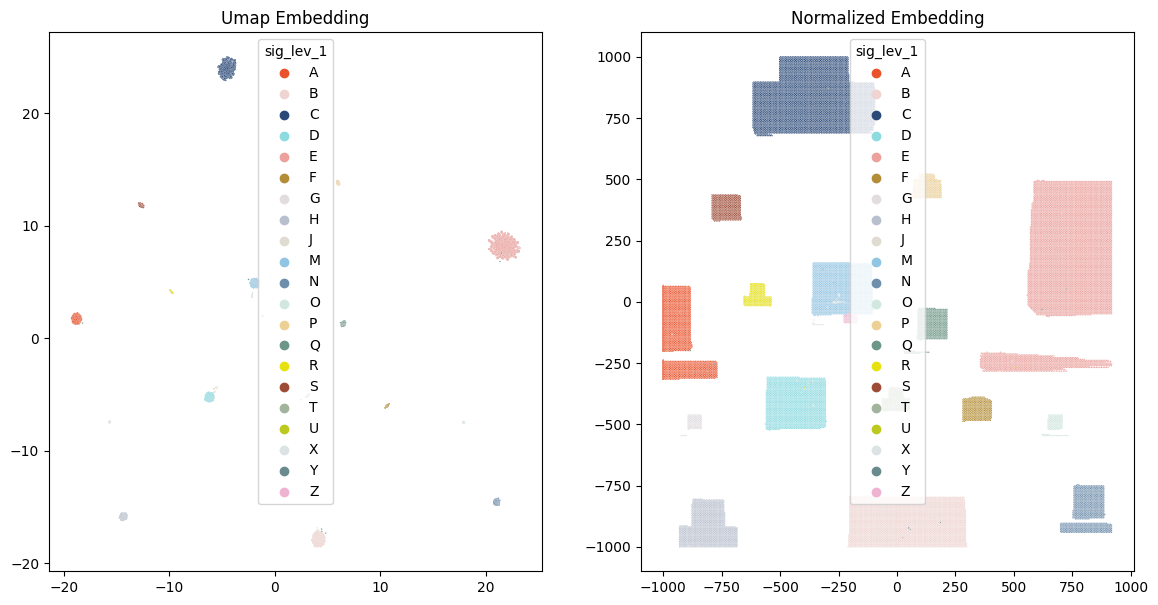

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
order = sorted(df.signature.astype(str).str[0].unique())

# Plot the embedding
sns.scatterplot(x=embedding_1[:, 0], 
                y=embedding_1[:, 1], 
                hue=df.sig_lev_1, 
                hue_order=order,
                palette=custom_colours, 
                ax=ax1, 
                s=1,)
ax1.set_title('Umap Embedding')
sns.scatterplot(x=normalized_embedding[:, 0], 
                y=normalized_embedding[:, 1], 
                hue=df.sig_lev_1, 
                hue_order=order, 
                palette=custom_colours,
                ax=ax2, 
                s=1,)
ax2.set_title('Normalized Embedding')


## Clustering 

In [152]:
# Clustering
labels = hdbscan.HDBSCAN(
    min_samples=1, # min-cluster-size: increase as dataset gets bigger
    min_cluster_size=100, # min-sample: how conservative the clustering is
).fit_predict(embedding_1)

# clustered points
clustered = (labels >= 0)

values = set(labels)
clusters_1 = [[index for index, cluster in enumerate(labels) if cluster==value] for value in values]

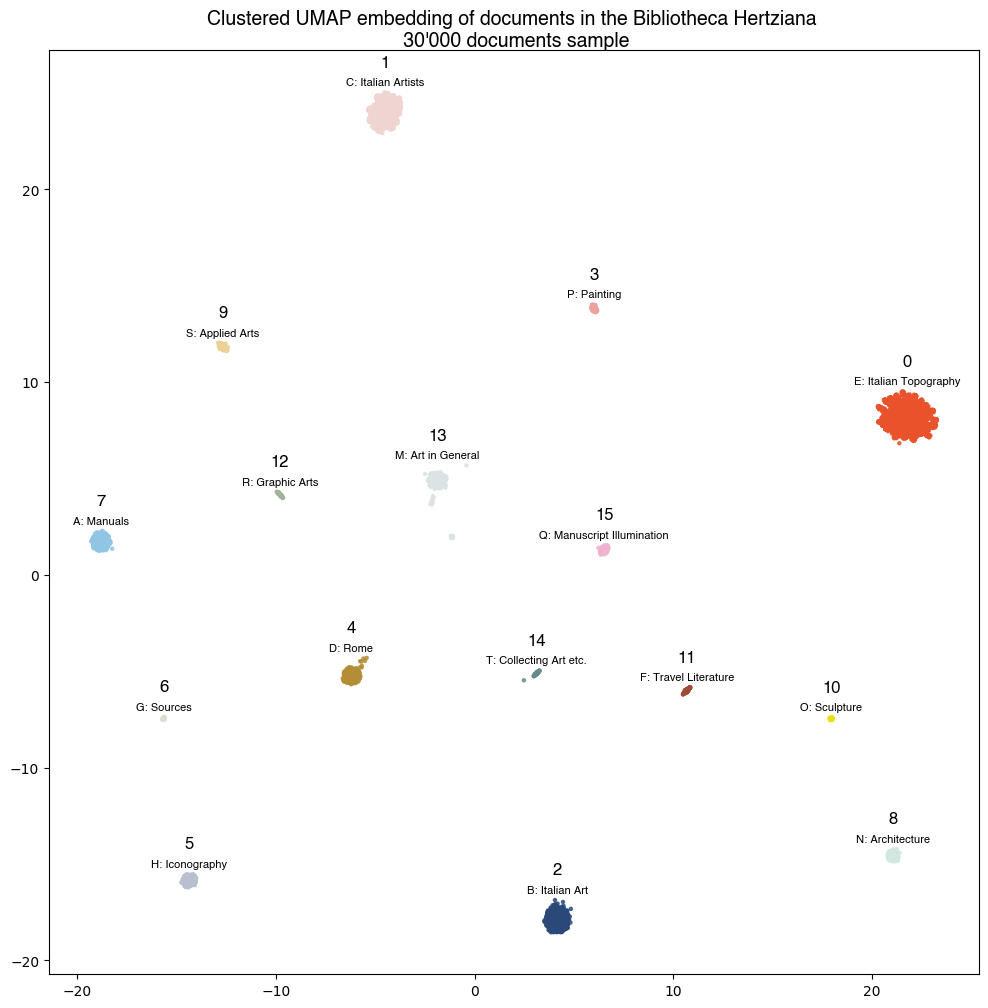

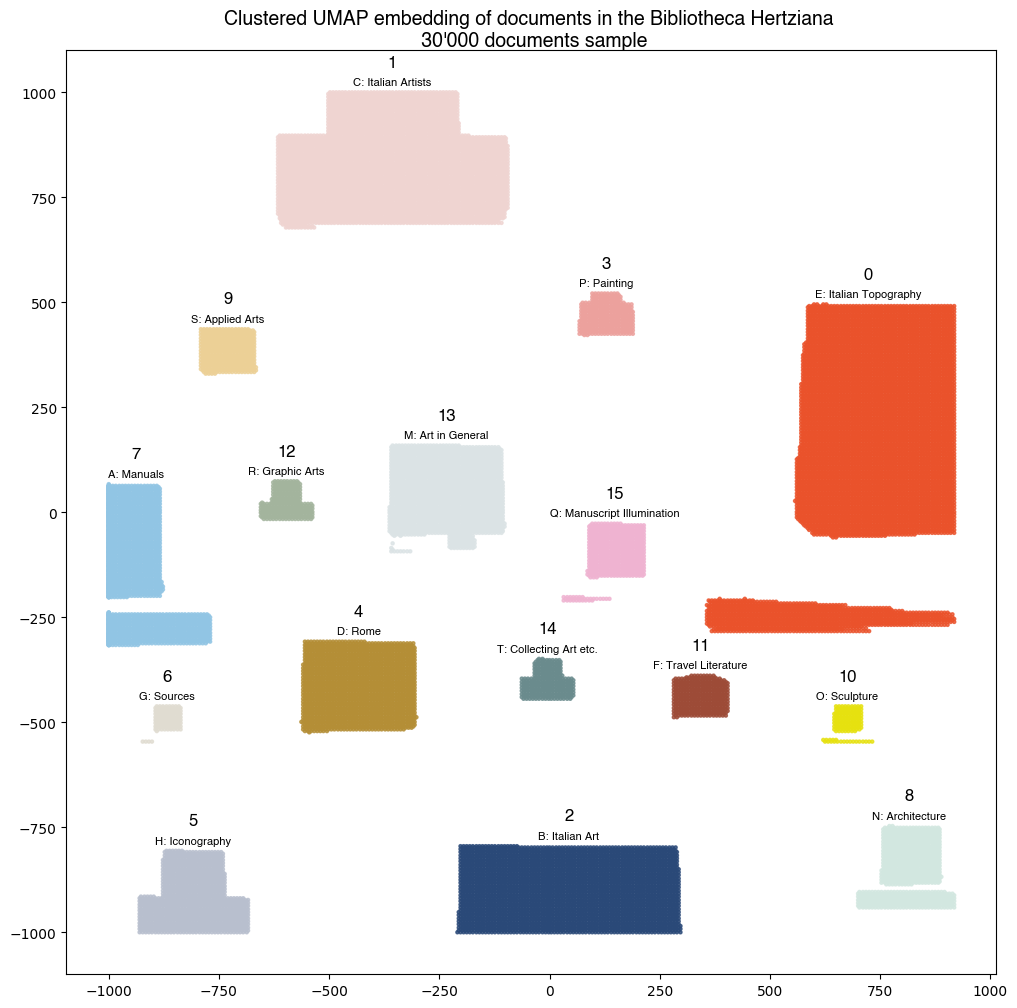

In [153]:
for i, emb in enumerate([embedding_1, normalized_embedding]):
    # Labels and center of clusters
    cluster_labels = []
    positions = []

    emb = emb

    for j, cluster_points in enumerate(clusters_1):

        cluster_sig = df.iloc[cluster_points].sig_lev_1.value_counts().index[0]
        cluster_labels.append((f'{j}', f'{cluster_sig}: {subject_dict[cluster_sig]}'))

        centroid = np.mean(emb[cluster_points, :], axis=0)
        max_y_index = cluster_points[np.argmax(emb[cluster_points, 1])]
        positions.append([centroid[0], emb[max_y_index, 1]])

    fig, ax = plt.subplots(figsize=(12, 12))

    # Unclustered datapoints
    plt.scatter(emb[~clustered, 0],
                emb[~clustered, 1],
                color=(0,0,0), #black points are not clustered
                s=5
                )

    # Clustered datapoints
    plt.scatter(emb[clustered, 0],
                emb[clustered, 1],
                c=labels[clustered],
                s=5,
                cmap=custom_cmap, 
                alpha= 0.8)

    # Add labels to clusters
    for label, position in zip(cluster_labels, positions):
        ax.annotate(label[0], xy=position, xytext=(0, 30),
                    textcoords='offset pixels', 
                    ha='center', va='center', 
                    fontsize=12, font='Helvetica')
        ax.annotate(label[1], xy=position, xytext=(0, 10),
                    textcoords='offset pixels', 
                    ha='center', va='center', 
                    fontsize=8, font='Helvetica')
        
    ax.set_title('Clustered UMAP embedding of documents in the Bibliotheca Hertziana \n 30\'000 documents sample', font= 'Helvetica', fontsize=14, ha='center', va='center')
    dpi = 500  # Adjust the DPI value as desired
    output_filename = f"data/plots/out_{i}.png"  # Specify the desired output filename and format

    plt.savefig(output_filename, dpi=dpi)   
    plt.show()

## UMAP on sig_lev_2

In [133]:
# Umap embedding for each cluster
embeddings_2 = []

for i, cluster in enumerate(clusters_1):

    n_neighbors = 30
    metric = 'russellrao'
    min_dist = 0.1

    # Extract data for current cluster
    data = df_cluster_2.iloc[cluster, :]

    # Apply UMAP to the cluster again
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, metric=metric, min_dist=min_dist,
                spread=1.0, random_state=42, verbose=False)
    x_umap = umap.fit_transform(data)

    embeddings_2.append(x_umap)

# Normalize embeddings
normalized_embeddings_2 = []
for emb in embeddings_2:
    normalized_embeddings_2.append(normalize(emb))

/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellrao distance metric; inverse_transform will be unavailable
  warn(
/Users/hana/anaconda3/envs/data/lib/python3.10/site-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for russellra

### Plot unclustered UMAP embedding 

/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_10032/1715928965.py:22: UserWarning: 
The palette list has fewer values (21) than needed (1225) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=emb[:, 0],
/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_10032/1715928965.py:22: UserWarning: The palette list has more values (21) than needed (5), which may not be intended.
  sns.scatterplot(x=emb[:, 0],
/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_10032/1715928965.py:22: UserWarning: The palette list has more values (21) than needed (15), which may not be intended.
  sns.scatterplot(x=emb[:, 0],
/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_10032/1715928965.py:22: UserWarning: The palette list has more values (21) than needed (4), which may not be intended.
  sns.scatterplot(x=emb[:, 0],
/var/folders/fs/xb9k_3m95gq0wjgk1kgw1nxr0000gn/T/ipykernel_10032/1715928965.py:22: UserWarning: The palette list has more value

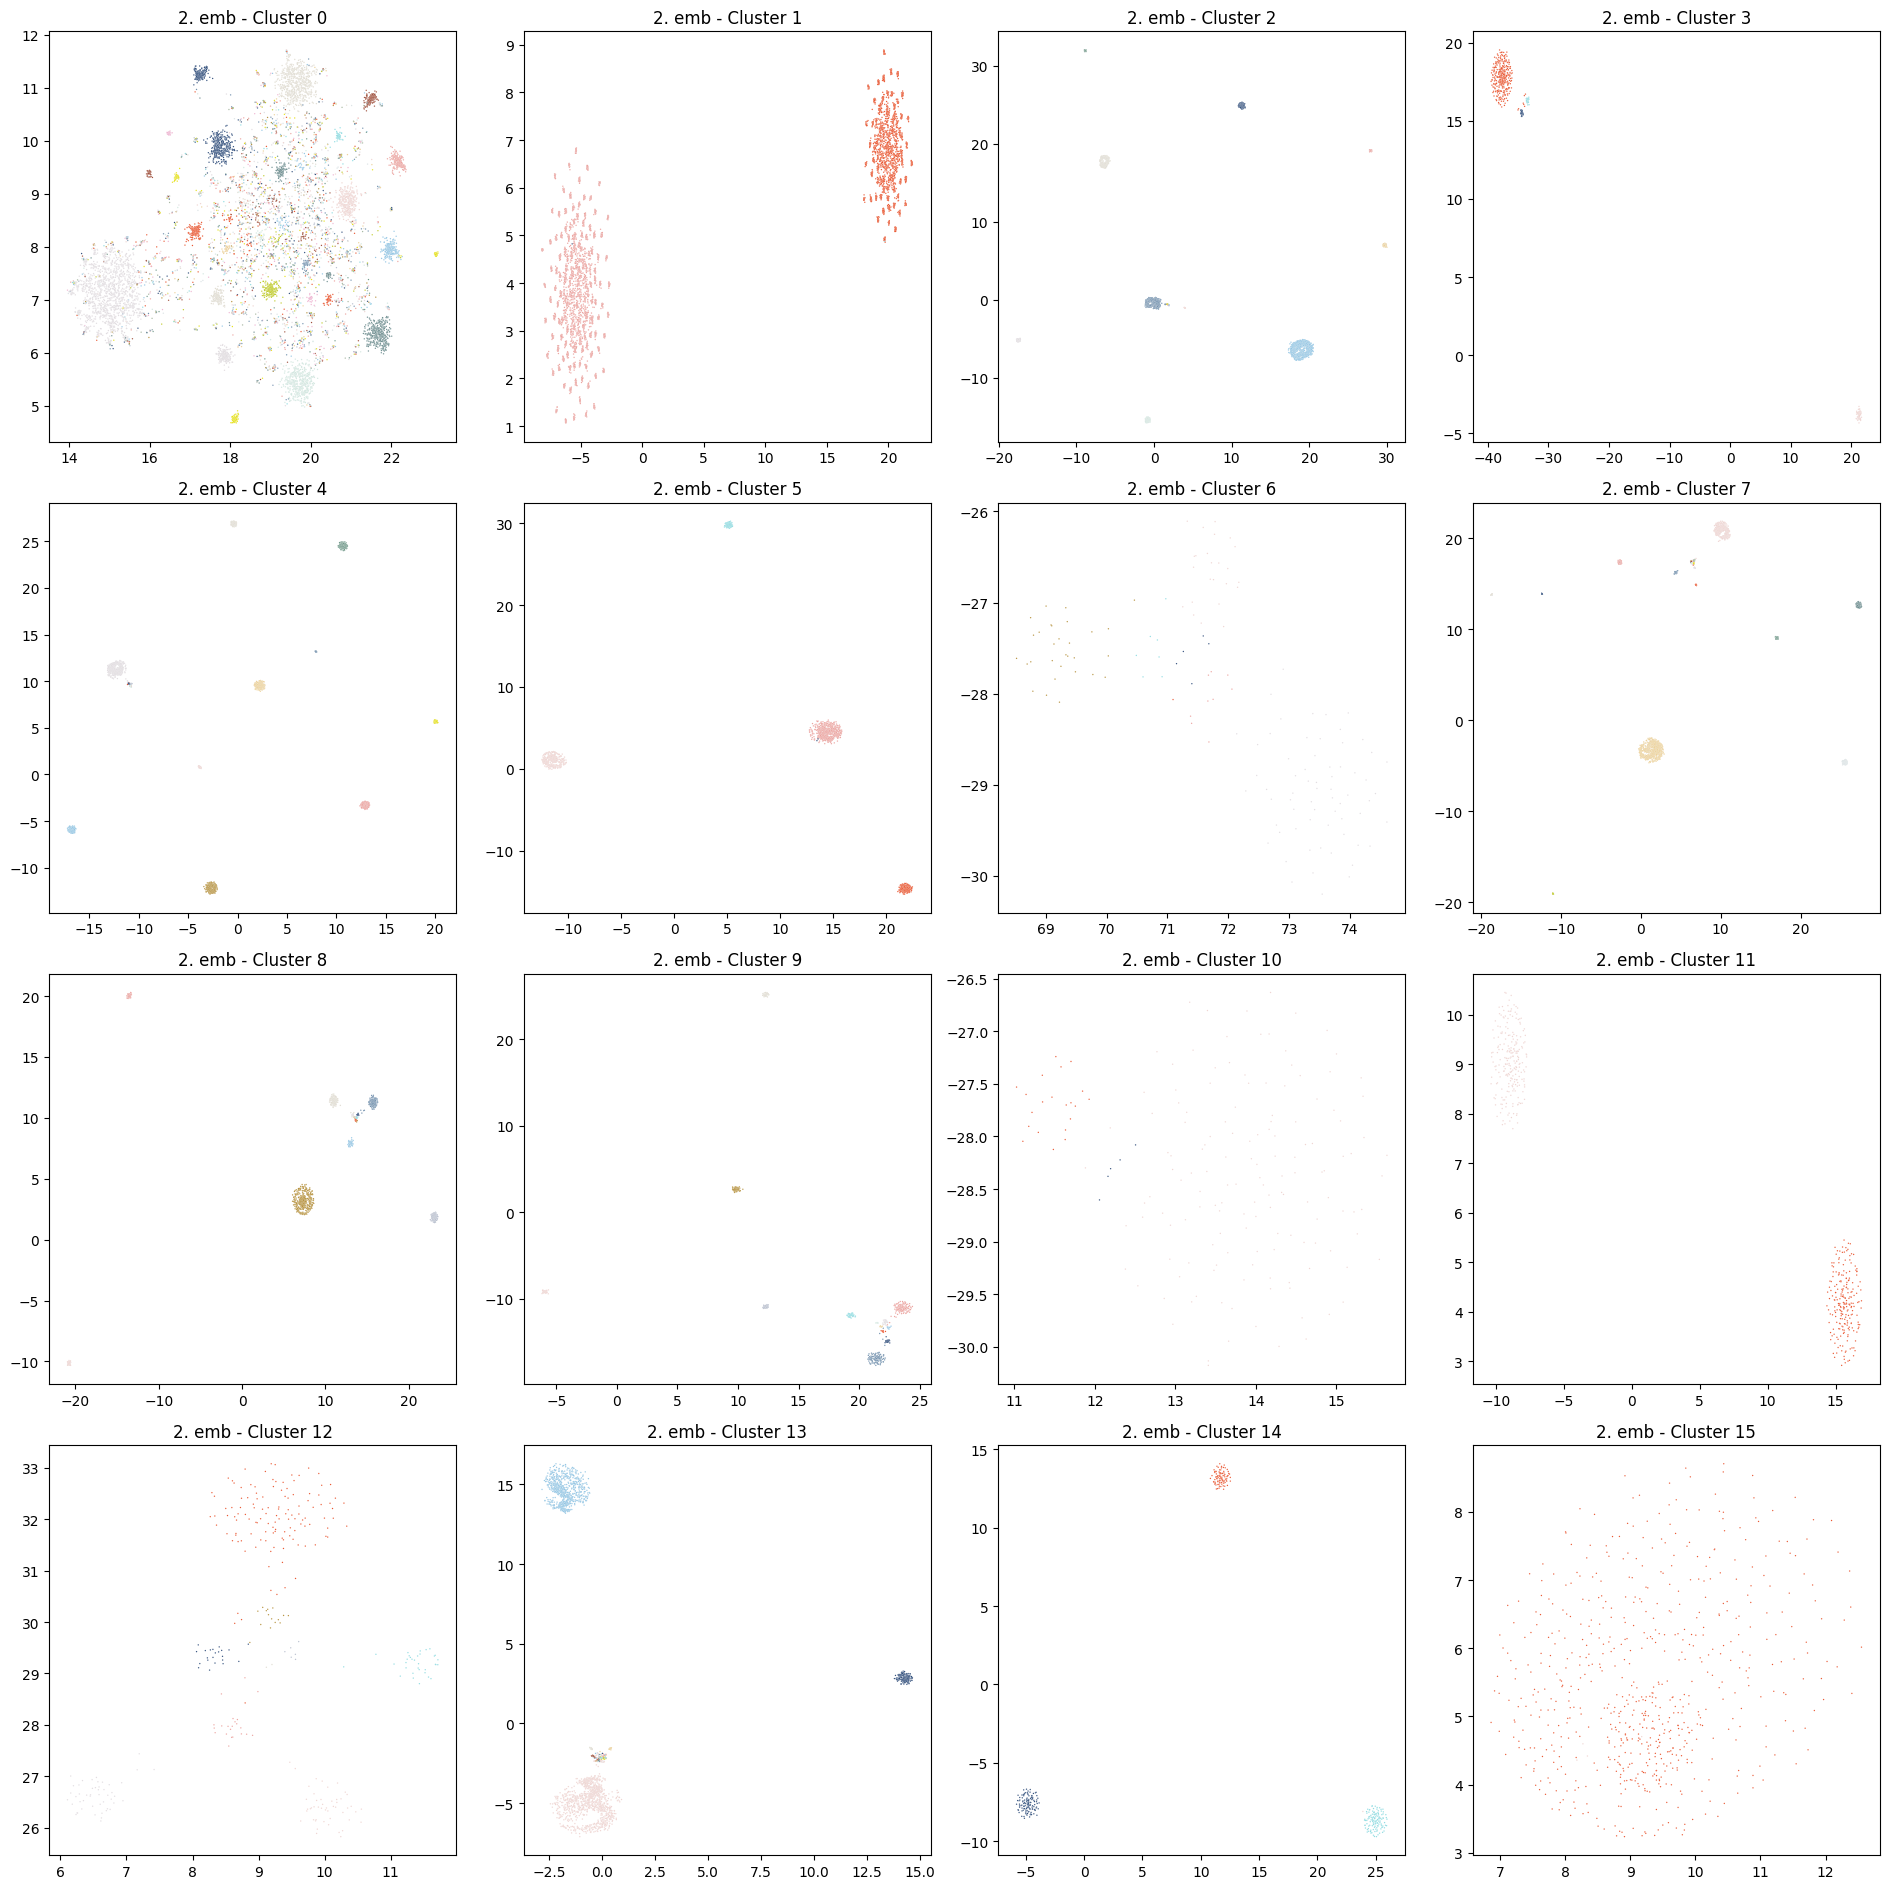

In [154]:
n_clusters = len(clusters_1)
n_rows = int(np.ceil(np.sqrt(n_clusters)))
n_cols = int(np.ceil(n_clusters / n_rows))

# Create the subplots for the level 2 embeddings
fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 19))
axes = axes.flatten()

for i, cluster in enumerate(clusters_1):

    ax = axes[i]
    
    emb = embeddings_2[i]
    labels = clusters_2[i][0]
    clustered = clusters_2[i][1]

    rows = df.iloc[cluster, :]
    order = sorted(rows.text_2.unique())


    # Clustered datapoints
    sns.scatterplot(x=emb[:, 0], 
                    y=emb[:, 1], 
                    hue=rows.text_2, 
                    hue_order=order, 
                    palette=custom_colours,
                    ax=ax, 
                    s=1,)
        
    ax.set_title('2. emb - Cluster {}'.format(i))
    ax.get_legend().remove()

# Hide any extra subplots
for j in range(n_clusters, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Cluster and Plot

In [155]:
# Clustering
clusters_2 = []
for i, embedding in enumerate(embeddings_2): 

    min_size = len(embedding) // 100 if len(embedding) // 100 > 1 else 20 # min size of cluster depending on number of sample points

    labels = hdbscan.HDBSCAN(
        min_samples=1, # min-cluster-size: increase as dataset gets bigger
        min_cluster_size=min_size, # min-sample: how conservative the clustering is
    ).fit_predict(embedding)

    # clustered points
    clustered = (labels >= 0)
    values = set(labels)
    subclusters = [[index for index, cluster in enumerate(labels) if cluster==value] for value in values]
    clusters_2.append((labels, clustered, subclusters))

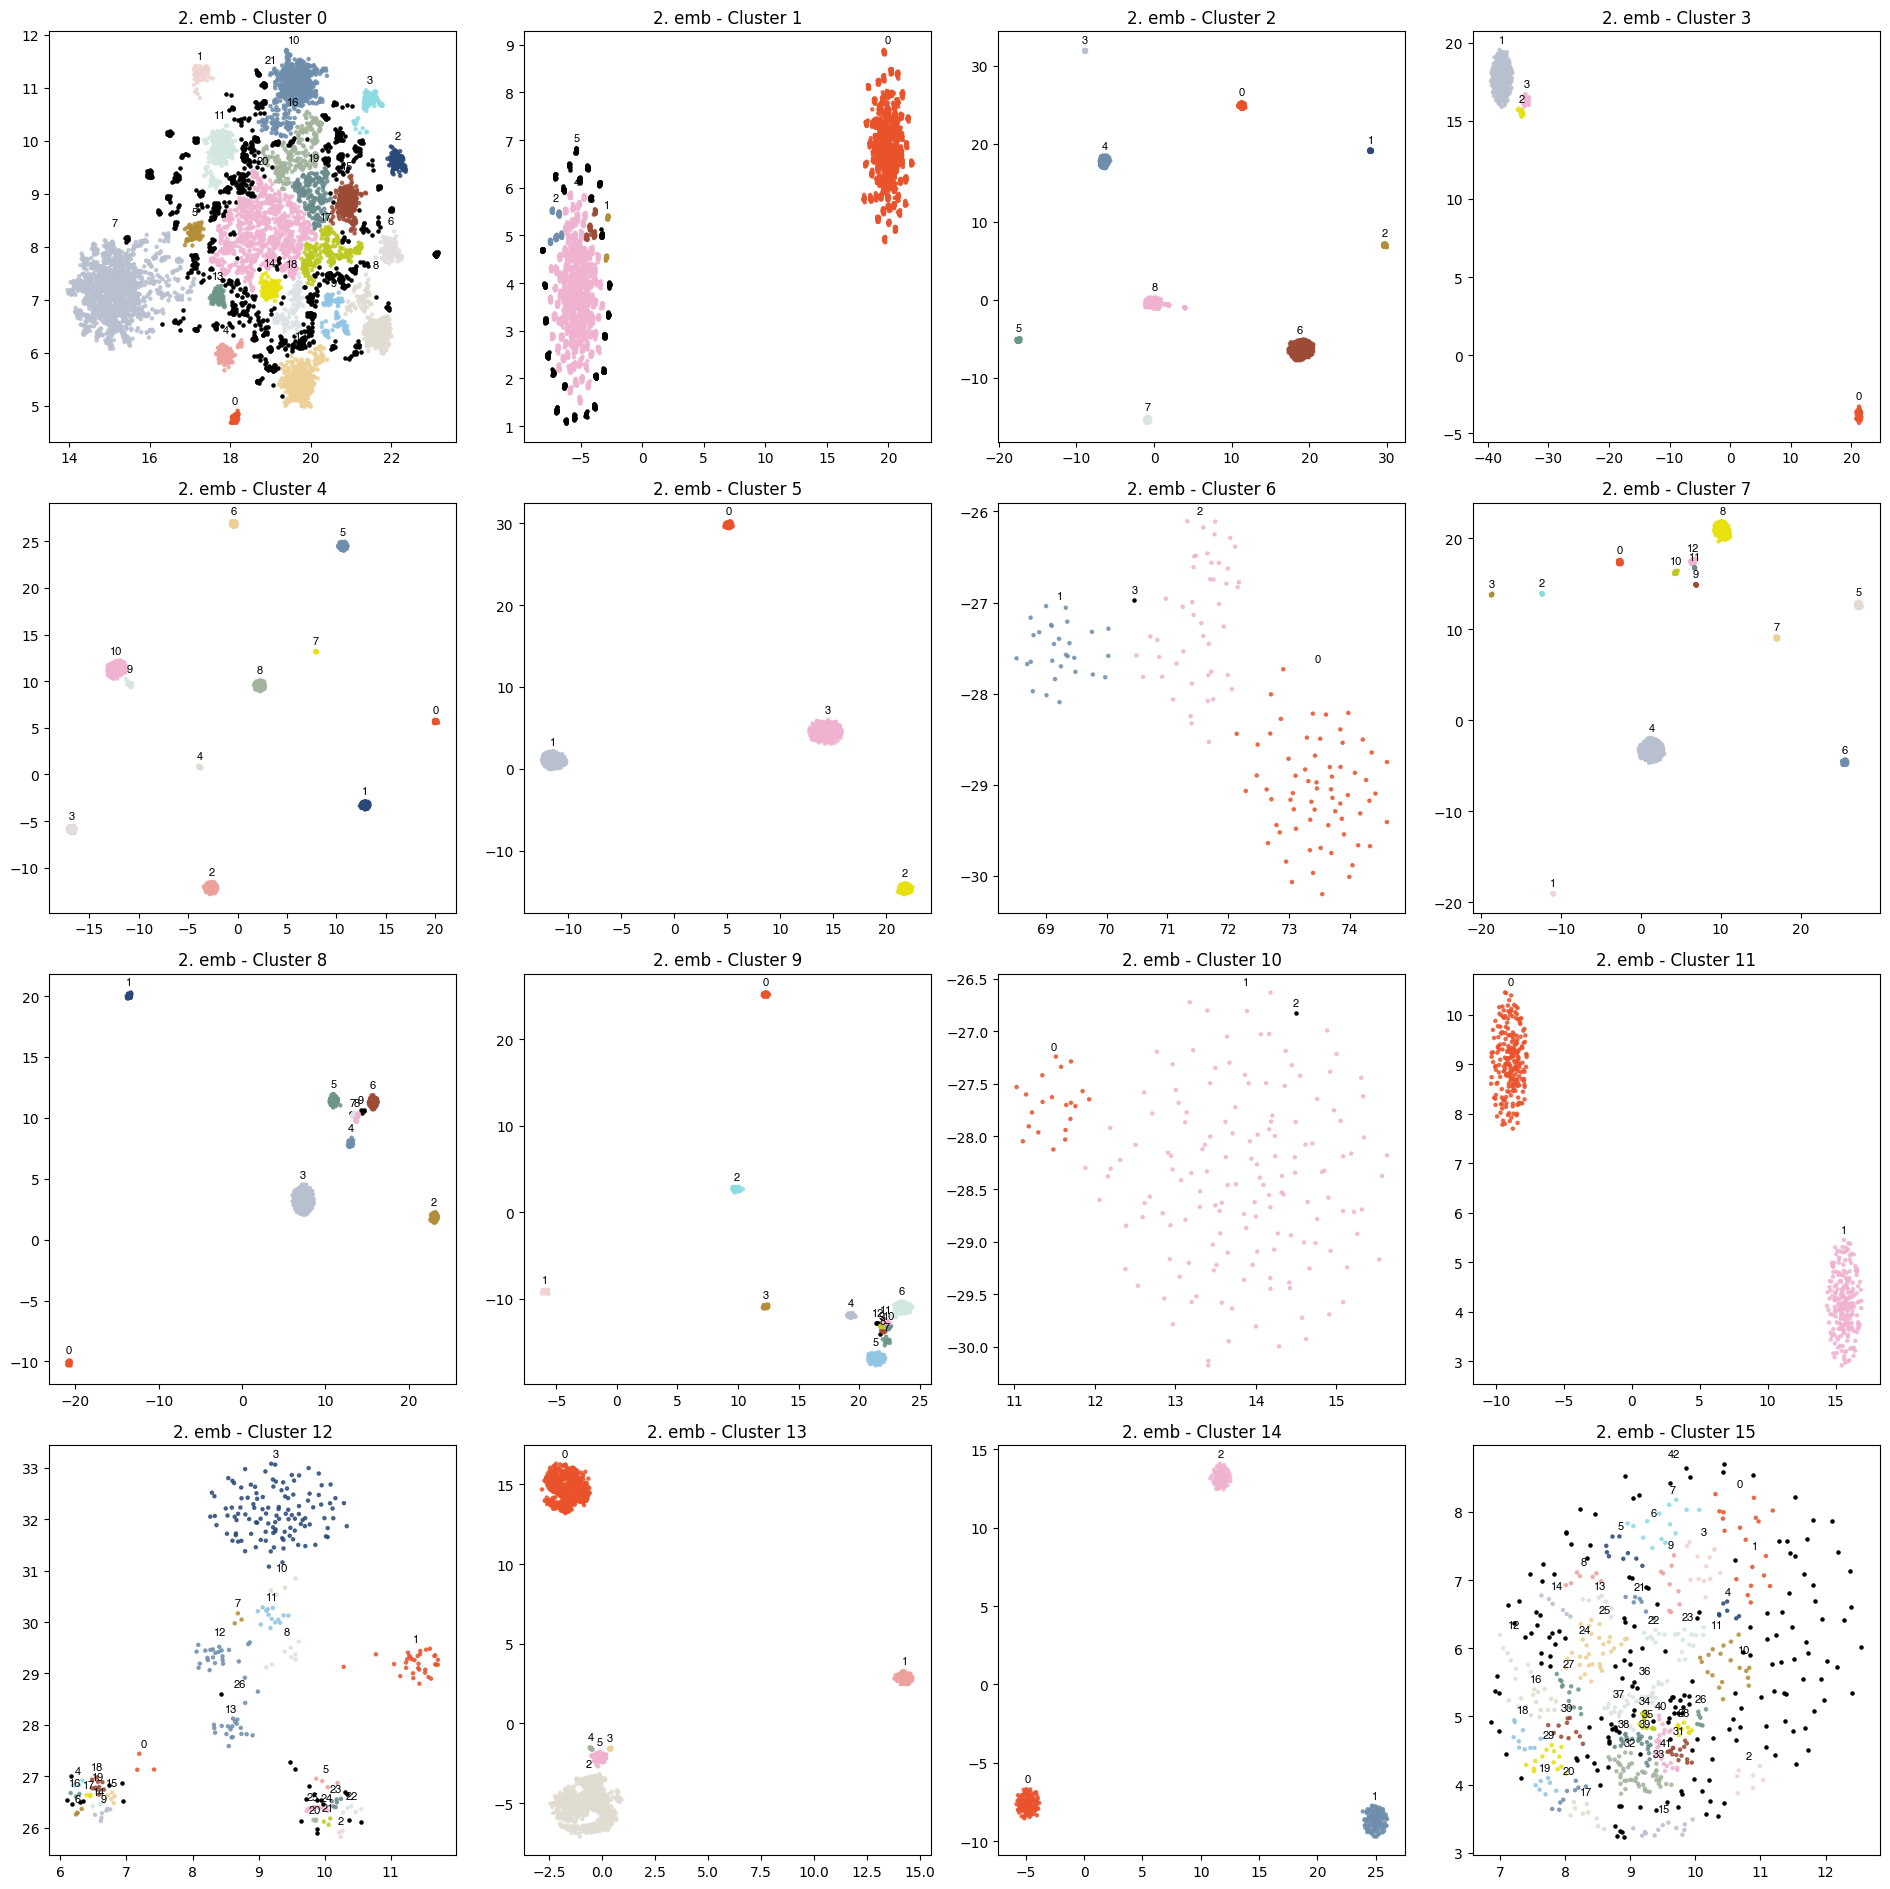

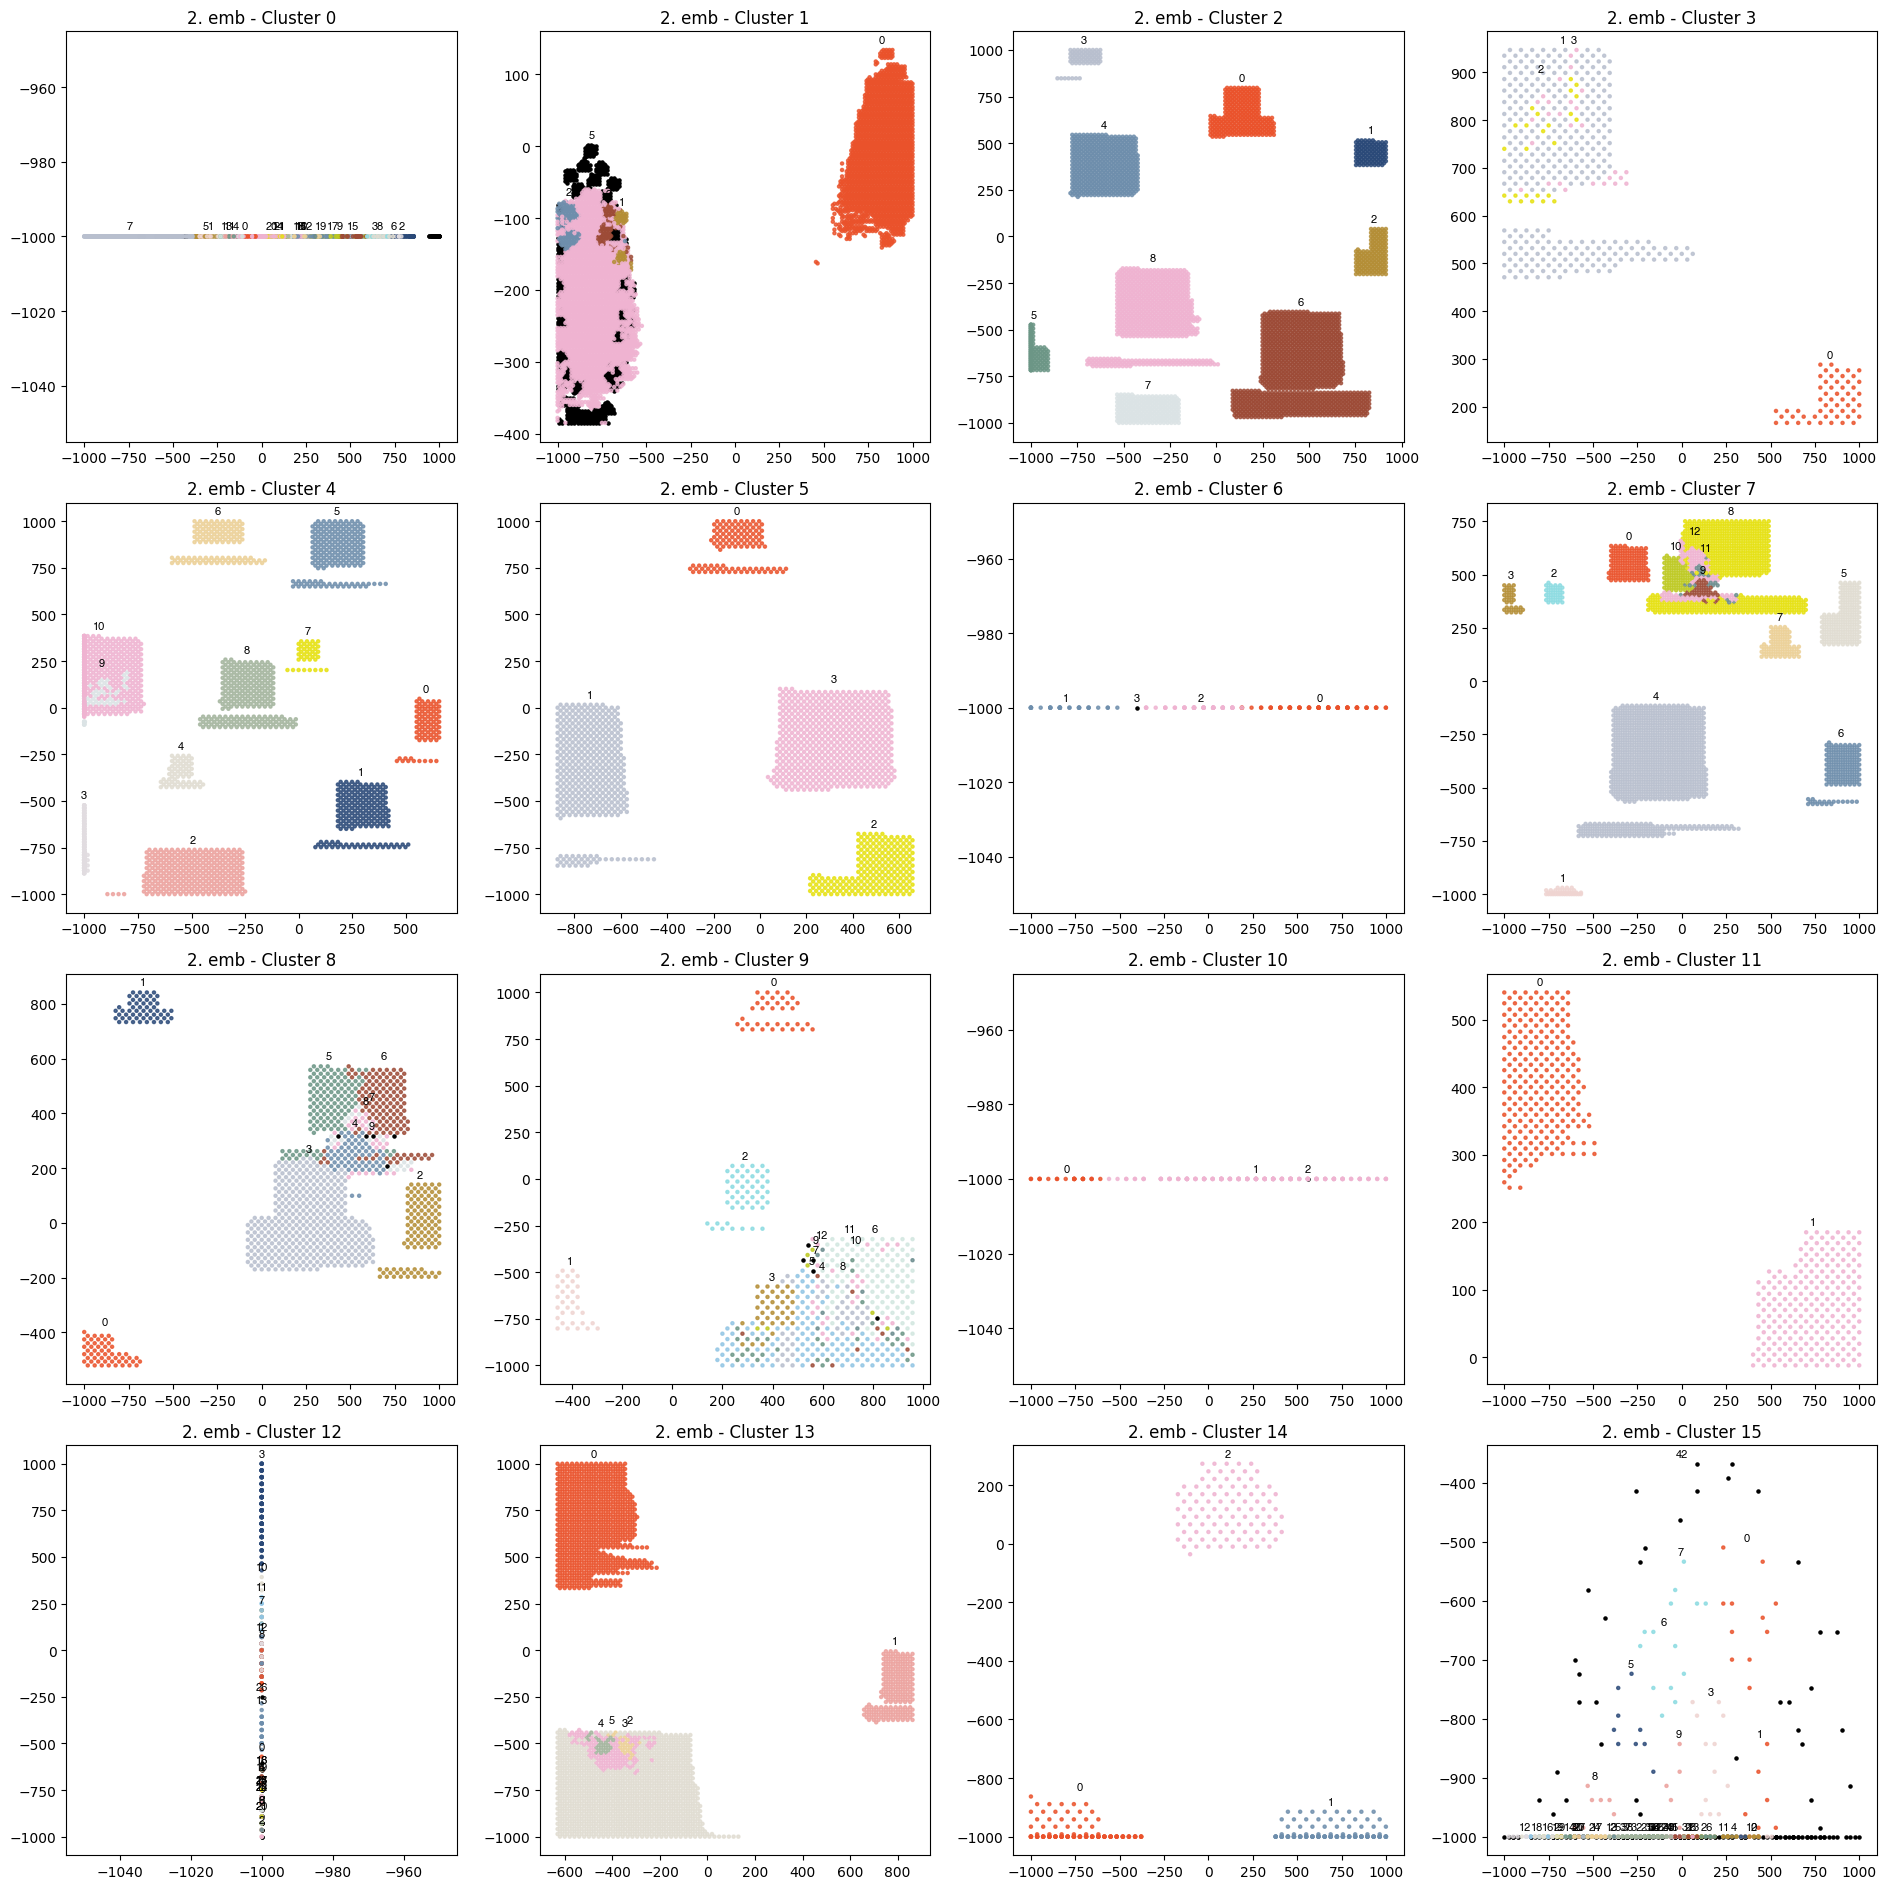

In [158]:
# Plot Unaligned and Aligned
for embeddings in [embeddings_2, normalized_embeddings_2]:

    n_clusters = len(clusters_1)
    n_rows = int(np.ceil(np.sqrt(n_clusters)))
    n_cols = int(np.ceil(n_clusters / n_rows))

    # Create the subplots for the level 2 embeddings
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(19, 19))
    axes = axes.flatten()

    for i, cluster in enumerate(clusters_1):

        emb = embeddings[i]
        labels = clusters_2[i][0]
        clustered = clusters_2[i][1]
        subclusters = clusters_2[i][2]

        positions, cluster_labels = [],[]

        for j, cluster_points in enumerate(subclusters):

            cluster_sig = df.iloc[cluster_points].text_2.value_counts().index[0]
            cluster_labels.append(f'{j}')

            centroid = np.mean(emb[cluster_points, :], axis=0)
            max_y_index = cluster_points[np.argmax(emb[cluster_points, 1])]
            positions.append([centroid[0], emb[max_y_index, 1]])

        ax = axes[i]

        # Unclustered datapoints
        ax.scatter(emb[~clustered, 0],
                    emb[~clustered, 1],
                    color=(0,0,0), #black points are not clustered
                    s=5
                    )

        # Clustered datapoints
        ax.scatter(emb[clustered, 0],
                    emb[clustered, 1],
                    c=labels[clustered],
                    s=5,
                    cmap=custom_cmap, 
                    alpha= 0.8)
        ax.set_title('2. emb - Cluster {}'.format(i))


        # Add labels to clusters
        for label, position in zip(cluster_labels, positions):
            ax.annotate(label, xy=position, xytext=(0, 10),
                        textcoords='offset pixels', 
                        ha='center', va='center', 
                        fontsize=8, font='Helvetica')

    # Hide any extra subplots
    for j in range(n_clusters, n_rows * n_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

